In [ ]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import talib 
from talib import abstract
plt.style.use('ggplot')

### 資料來源:TEJ資料庫

In [ ]:
data = pd.read_excel("/content/2308.xlsx",index_col = 0).round(2)
data.index = pd.DatetimeIndex(data.index)
data

,volume,open,high,low,close
date,,,,,
2019-10-03,4350,123.35,124.75,122.89,123.82
2019-10-04,11273,122.89,123.82,121.96,122.42
2019-10-07,6746,123.82,125.21,123.35,124.28
2019-10-08,6475,124.75,124.75,122.42,122.42
2019-10-09,16298,121.02,121.02,118.23,118.23
...,...,...,...,...,...
2022-10-03,2777,249.50,254.50,248.50,252.00
2022-10-04,3870,256.00,259.50,254.50,258.50
2022-10-05,8613,265.00,271.00,261.50,269.50


In [ ]:
feeRate = 0.001425   #手續費
tax = 0.003       #稅
length = 110
K = 0.05



data['MA'] = data['close'].rolling(window= length, center=False).mean()
data["rsi_12"] = abstract.RSI(data.close, timeperiod = 12)
data["rsi_6"] = abstract.RSI(data.close, timeperiod = 6)

df = data[244:]
df.head()

,volume,open,high,low,close,MA,rsi_12,rsi_6
date,,,,,,,,
2020-10-05,9398,181.30,184.18,180.34,181.78,164.586364,53.574316,61.805906
2020-10-06,5266,182.74,183.70,180.82,183.70,165.113818,56.668381,66.723861
2020-10-07,5769,184.18,184.18,181.30,183.22,165.611545,55.656761,64.242268
2020-10-08,5057,185.14,185.14,182.74,185.14,166.109818,58.861371,69.658821
2020-10-12,9609,188.97,189.45,185.14,188.01,166.668000,63.198323,76.141541


### 統一由隔天開盤時進場

               profit  profitfee
date                            
2020-10-05   0.000000   0.000000
2020-10-06   0.000000   0.000000
2020-10-07   0.788005   0.788005
2020-10-08   1.313341   1.313341
2020-10-12   3.409215   3.409215
...               ...        ...
2022-10-03  53.689047  30.027963
2022-10-04  56.155840  32.494756
2022-10-05  59.571400  35.910316
2022-10-06  62.227946  38.566862
2022-10-07  65.074246  40.801293

[494 rows x 2 columns]


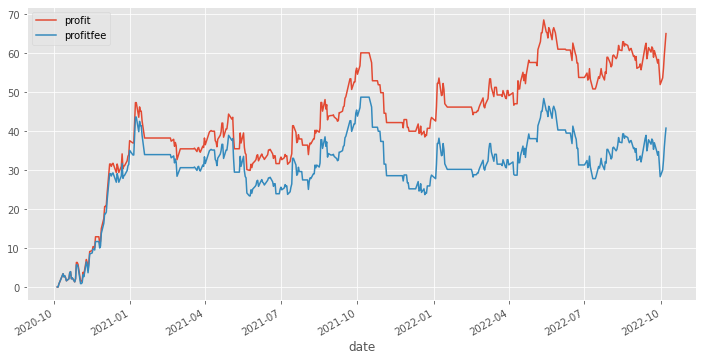

In [ ]:
fund = 1000   
money = 100
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
profit_fee_list_buy_realized = []
profit_fee_list_short_realized = []

for i in range(len(df)):

    if i == len(df)-1:
        break

    ## 進場邏輯
    entryLong = df["rsi_12"][i] >= 50 and df['rsi_6'][i] >= df["rsi_12"][i] and df["close"][i] > df["MA"][i]
    entrySellShort = df["rsi_12"][i]  <= 50  and df['rsi_6'][i] <= df["rsi_12"][i] and df["close"][i] < df["MA"][i]
    
    ## 出場邏輯
    exitShort = df["rsi_12"][i]  < 50 and df['close'][i] < df["MA"][i]
    exitBuyToCover = df["rsi_12"][i]  > 50  and df['close'][i] < df["MA"][i]

    ## 停利停損邏輯
    if BS == "B":
      stopLoss = df['close'][i] <= df['open'][t] * (1-K)
      stopProfit = df['close'][i] >= df['open'][t] * (1+K)
    elif BS == 'S':
      stopLoss = df['close'][i] >= df['open'][t] * (1+K)
      stopProfit = df['close'][i] <= df['open'][t] * (1-K)

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong:
            BS = 'B'
            temp = df["open"][i+1]
            tempsize = money  / temp
            t = i+1
            buy.append(t)

        elif entrySellShort:
            BS = 'S'
            temp = df["open"][i+1]
            tempsize = money  / temp
            t = i+1
            sellshort.append(t)

        
    elif BS == 'B':
        profit = tempsize * (df['open'][i+1] - df['open'][i])
        profit_list.append(profit)
            
        if exitShort or i == len(df)-2 or stopLoss or stopProfit:
            pl_round = tempsize * (df['open'][i+1] - df['open'][t])
            profit_fee = profit - money * feeRate - (money+pl_round) * (feeRate+tax)
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None

            # Realized PnL
            profit_fee_realized = pl_round - money * feeRate - (money+pl_round) * (feeRate+tax)
            profit_fee_list_realized.append(profit_fee_realized)
            profit_fee_list_buy_realized.append(profit_fee_realized)
            

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = tempsize * (df['open'][i] - df['open'][i+1])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df)-2 or stopLoss or stopProfit:
            pl_round = tempsize * (df['open'][t] - df['open'][i+1])
            profit_fee = profit - money * feeRate - (money+pl_round) * (feeRate+tax)
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None

            # Realized PnL
            profit_fee_realized = pl_round - money * feeRate - (money+pl_round) * (feeRate+tax)
            profit_fee_list_realized.append(profit_fee_realized)
            profit_fee_list_short_realized.append(profit_fee_realized)
            

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=df.index)
print(equity)
equity.plot(grid=True, figsize=(12, 6));

In [ ]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

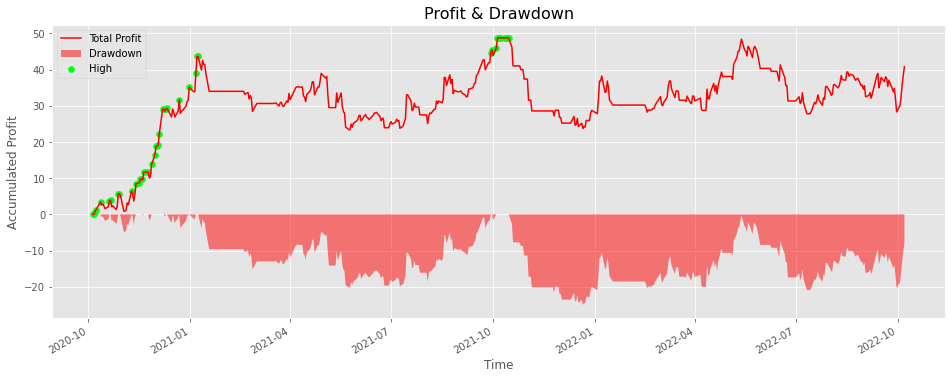

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

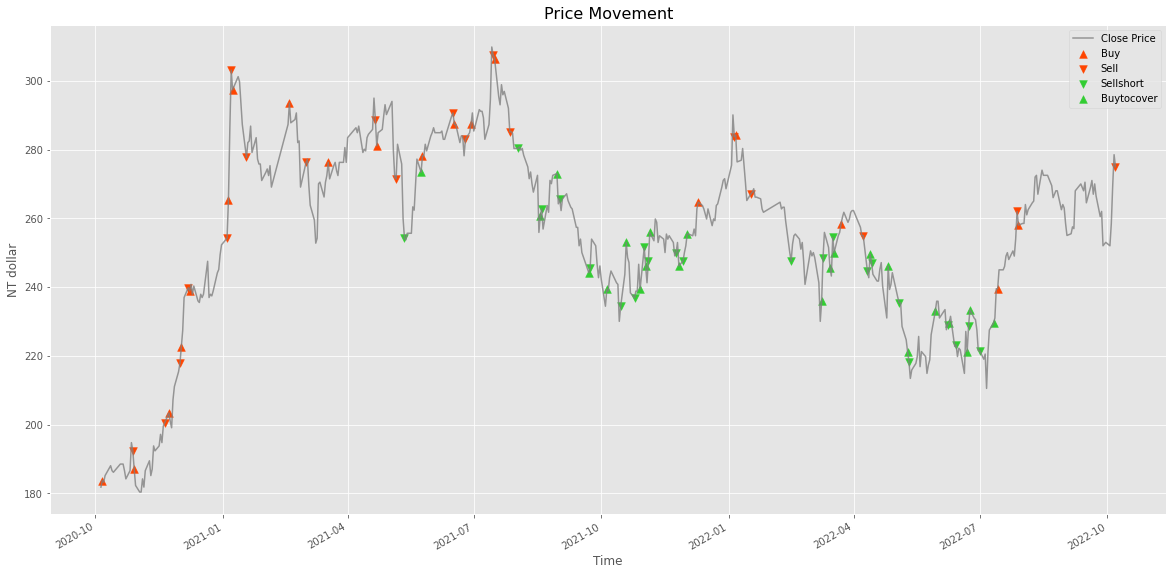

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))

df['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(df['close'].iloc[sellshort].index, df['close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(df['close'].iloc[buytocover].index, df['close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('NT dollar')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

### 績效指標

In [ ]:
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')

profit: $40.8
return: 4.08%
mdd: 2.39%
calmarRatio: 1.71
tradeTimes: 41
winRate: 48.78%
profitFactor: 1.43
winLossRatio: 1.5


### 空單勝率

In [ ]:
short_data=pd.DataFrame({'sellshort':sellshort, 'short_realized':profit_fee_list_short_realized })
sellshort_win_num = []

for i in range(short_data.shape[0]):
  if short_data["short_realized"][i] > 0:
    sellshort_win_num.append(1)

print("sellshort_win_ratio = ",sum(sellshort_win_num)/short_data.shape[0])

sellshort_win_ratio =  0.36363636363636365


### 多單勝率

In [ ]:
buy_data=pd.DataFrame({'buy':buy, 'buy_realized':profit_fee_list_buy_realized })
buy_win_num = []

for i in range(buy_data.shape[0]):
  if buy_data["buy_realized"][i] > 0:
    buy_win_num.append(1)

print("buy_win_ratio = ",sum(buy_win_num)/buy_data.shape[0])

buy_win_ratio =  0.631578947368421


### 參數最佳化

In [ ]:
optimizationList = []

for length in range(10,250,10):
  for K in np.arange(0.01,0.11,0.01):
        
        df['MA'] = data['close'].rolling(window=length, center=False).mean()
      
        fund = 1000
        money = 100 
        feeRate = 0.001425  
        tax = 0.003 

        BS = None
        buy = []
        sell = []
        sellshort = []
        buytocover = []
        profit_list = [0]
        profit_fee_list = [0]
        profit_fee_list_realized = []

        for i in range(len(df)):

          if i == len(df)-1:
              break

          ## 進場邏輯
          entryLong = df["rsi_12"][i] >= 50 and df['rsi_6'][i] >= df["rsi_12"][i] and df["close"][i] > df["MA"][i]
          entrySellShort = df["rsi_12"][i]  <= 50  and df['rsi_6'][i] <= df["rsi_12"][i] and df["close"][i] < df["MA"][i]
          
          ## 出場邏輯
          exitShort = df["rsi_12"][i]  < 50 and df['close'][i] < df["MA"][i]
          exitBuyToCover = df["rsi_12"][i]  > 50  and df['close'][i] < df["MA"][i]

          ## 停利停損邏輯
          if BS == "B":
            stopLoss = df['close'][i] <= df['open'][t] * (1-K)
            stopProfit = df['close'][i] >= df['open'][t] * (1+K)
          elif BS == 'S':
            stopLoss = df['close'][i] >= df['open'][t] * (1+K)
            stopProfit = df['close'][i] <= df['open'][t] * (1-K)

          if BS == None:
              profit_list.append(0)
              profit_fee_list.append(0)
              
              if entryLong:
                  BS = 'B'
                  temp = df["open"][i+1]
                  tempsize = money  / temp
                  t = i+1
                  buy.append(t)

              elif entrySellShort:
                  BS = 'S'
                  temp = df["open"][i+1]
                  tempsize = money  / temp
                  t = i+1
                  sellshort.append(t)

              
          elif BS == 'B':
              profit = tempsize * (df['open'][i+1] - df['open'][i])
              profit_list.append(profit)
                  
              if exitShort or i == len(df)-2 or stopLoss or stopProfit:
                  pl_round = tempsize * (df['open'][i+1] - df['open'][t])
                  profit_fee = profit - money * feeRate - (money+pl_round) * (feeRate+tax)
                  profit_fee_list.append(profit_fee)
                  sell.append(i+1)
                  BS=None

                  # Realized PnL
                  profit_fee_realized = pl_round - money * feeRate - (money+pl_round) * (feeRate+tax)
                  profit_fee_list_realized.append(profit_fee_realized)
                  

              else:
                  profit_fee = profit
                  profit_fee_list.append(profit_fee)
                  
          elif BS == 'S': 
              profit = tempsize * (df['open'][i] - df['open'][i+1])
              profit_list.append(profit)
              
              if exitBuyToCover or i == len(df)-2 or stopLoss or stopProfit:
                  pl_round = tempsize * (df['open'][t] - df['open'][i+1])
                  profit_fee = profit - money * feeRate - (money+pl_round) * (feeRate+tax)
                  profit_fee_list.append(profit_fee)
                  buytocover.append(i+1)
                  BS=None

                  # Realized PnL
                  profit_fee_realized = pl_round - money * feeRate - (money+pl_round) * (feeRate+tax)
                  profit_fee_list_realized.append(profit_fee_realized)
          

              else:
                  profit_fee = profit
                  profit_fee_list.append(profit_fee)


        equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=df.index)
        equity['equity'] = equity['profitfee'] + fund
        equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
        equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
        ret = equity['equity'][-1]/equity['equity'][0] - 1
        mdd = abs(equity['drawdown_percent'].min())
        calmarRatio = ret / mdd
        
        optimizationList.append([ length, K, ret, mdd, calmarRatio])

   length     K    return       mdd  calmarRatio
0      10  0.01 -0.047474  0.056469    -0.840712
1      10  0.02 -0.038508  0.055839    -0.689614
2      10  0.03 -0.057434  0.077454    -0.741521
3      10  0.04 -0.035565  0.064601    -0.550539
4      10  0.05 -0.024656  0.048519    -0.508171


[Text(0.5, 1.0, 'Calmar Ratio')]

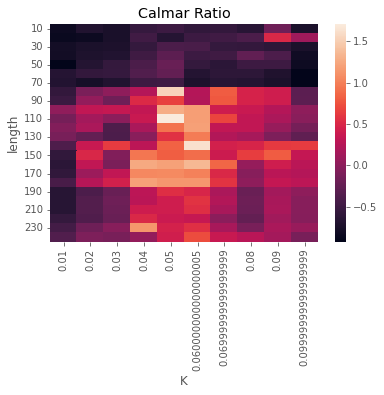

In [ ]:
optResult = pd.DataFrame(optimizationList, columns=["length", "K", 'return',"mdd" ,'calmarRatio'])
print(optResult.head())

pic = optResult.pivot('length', 'K', 'calmarRatio')
sns.heatmap(data = pic).set(title='Calmar Ratio')